### Training Sentiment Analysis Model Using LSTM 

#### Data Preparation

In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
def create_imdb_review_dataset(main_folder_path, output_csv_path):
    """
    Creates a Pandas DataFrame from movie review files in a given folder,
    including sentiment and URLs, and saves it to a CSV file.

    Args:
        main_folder_path (str): Path to the main folder containing review files
                                and URL files (e.g., "aclImdb/test").
        output_csv_path (str): Path to save the output CSV file (e.g., "test_reviews.csv").
    """

    url_files = {
        "pos": os.path.join(main_folder_path, "urls_pos.txt"),
        "neg": os.path.join(main_folder_path, "urls_neg.txt"),
    }

    url_dict = {}
    for sentiment, url_file in url_files.items():
        try:  # Handle potential file not found errors
            with open(url_file, "r", encoding="utf-8") as f:
                url_dict[sentiment] = [line.strip() for line in f.readlines()]
        except FileNotFoundError:
            print(f"Warning: URL file {url_file} not found. URLs will be None.")
            url_dict[sentiment] = []  # Initialize to empty list

    data = []
    for sentiment in ["pos", "neg"]:
        folder_path = os.path.join(main_folder_path, sentiment)
        try:  # Handle potential folder not found errors
            file_names = sorted(os.listdir(folder_path))
        except FileNotFoundError:
            print(f"Warning: Sentiment folder {folder_path} not found. Skipping.")
            continue  # Go to the next sentiment

        for i, filename in enumerate(file_names):
            file_path = os.path.join(folder_path, filename)
            try:  # Handle potential file read errors
                with open(file_path, "r", encoding="utf-8") as file:
                    review_text = file.read().strip()
            except FileNotFoundError:
                print(f"Warning: Review file {file_path} not found. Skipping.")
                continue # Go to the next file

            url = url_dict[sentiment][i] if i < len(url_dict[sentiment]) else None
            data.append({"review": review_text, "sentiment": sentiment, "url": url})

    df = pd.DataFrame(data)
    df.to_csv(output_csv_path, index=False)
    print(f"DataFrame saved to {output_csv_path}")
    return df

In [4]:
def prepare_train_test_dfs(train_df,test_df):
    consolidated_df = pd.concat([train_df, test_df])
    train_df_, test_df_ = train_test_split(consolidated_df, test_size=0.2, stratify=consolidated_df["sentiment"], random_state=42)
    train_df_["sentiment"] = train_df_["sentiment"].replace("unsup", "neutral")
    test_df_["sentiment"] = test_df_["sentiment"].replace("unsup", "neutral")
    train_df_ = train_df_.drop(columns=["url","review_length"])
    test_df_ = test_df_.drop(columns=["url","review_length"])
    train_df_.to_csv("train_df_.csv", index=False)
    test_df_.to_csv("test_df_.csv", index=False)
    return train_df_,test_df_



In [4]:
train_df_ = pd.read_csv("train_df_.csv")
test_df_ = pd.read_csv("test_df_.csv")

#### EDA

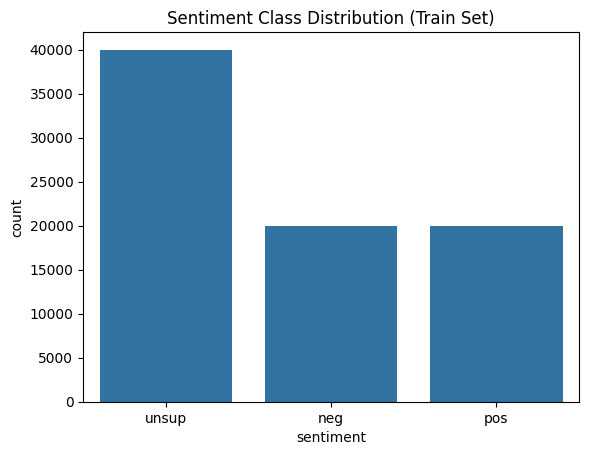

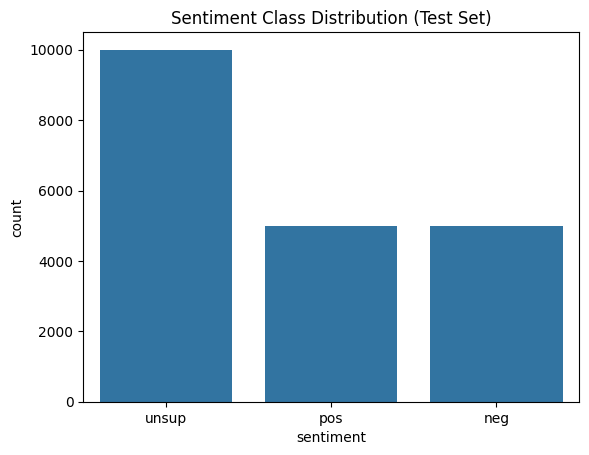

In [5]:
# Plot class distribution
sns.countplot(x=train_df_["sentiment"])
plt.title("Sentiment Class Distribution (Train Set)")
plt.show()

sns.countplot(x=test_df_["sentiment"])
plt.title("Sentiment Class Distribution (Test Set)")
plt.show()


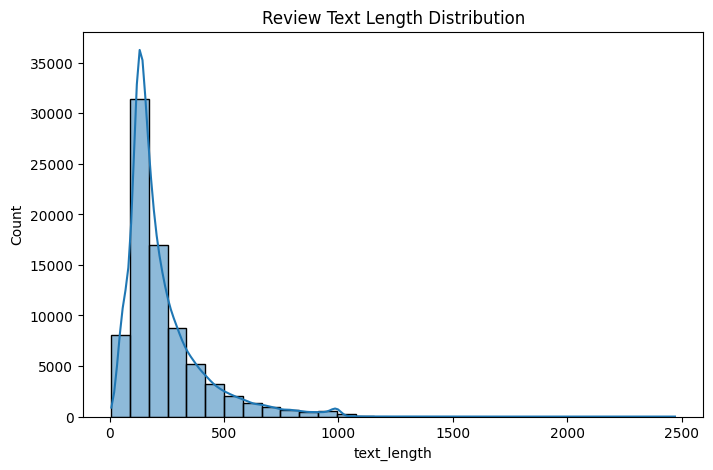

In [6]:
train_df_["text_length"] = train_df_["review"].apply(lambda x: len(x.split()))
test_df_["text_length"] = test_df_["review"].apply(lambda x: len(x.split()))

# Plot text length distribution
plt.figure(figsize=(8,5))
sns.histplot(train_df_["text_length"], bins=30, kde=True)
plt.title("Review Text Length Distribution")
plt.show()


In [7]:
print("Missing values in train:\n", train_df_.isnull().sum())
print("Missing values in test:\n", test_df_.isnull().sum())

Missing values in train:
 review         0
sentiment      0
url            0
text_length    0
dtype: int64
Missing values in test:
 review         0
sentiment      0
url            0
text_length    0
dtype: int64


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer


# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize all reviews and get their lengths
review_lengths = [len(tokenizer.encode(text, truncation=False)) for text in train_df_["review"]]

# Print basic statistics
print(f"Max review length: {max(review_lengths)}")
print(f"95th percentile: {np.percentile(review_lengths, 95)}")
print(f"90th percentile: {np.percentile(review_lengths, 90)}")
print(f"Median review length: {np.median(review_lengths)}")


Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors


Max review length: 3446
95th percentile: 807.0
90th percentile: 613.0
Median review length: 233.0


In [82]:
train_df = train_df_[['review','sentiment']]
test_df= test_df_[['review','sentiment']]

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
vocab_size = tokenizer.vocab_size
print("Vocab Size :",vocab_size)

config = {
    "vocab_size": tokenizer.vocab_size, 
    "embed_dim": 300,
    "hidden_dim": 256,
    "output_dim": 3,  # Negative, Neutral, Positive
    "num_layers": 2,
    "dropout": 0.5
}

Device: cpu
Vocab Size : 30522


In [84]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=512):
        self.encodings = tokenizer(df["review"].tolist(), 
                                   truncation=True, padding="max_length",
                                   max_length=max_len, return_tensors="pt")
        self.labels = torch.tensor(df["sentiment"].tolist(), dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],  
            "labels": self.labels[idx]
        } 


In [89]:
train_df["sentiment"] = train_df["sentiment"].replace("unsup", "neutral")
test_df["sentiment"] = test_df["sentiment"].replace("unsup", "neutral")
label_map = {"neg": 0, "neutral": 1, "pos": 2}
train_df["sentiment"] = train_df["sentiment"].map(label_map)  
test_df["sentiment"] = test_df["sentiment"].map(label_map) 



In [106]:
train_sample, _ = train_test_split(train_df, train_size=8000, stratify=train_df["sentiment"], random_state=42)
test_sample, _ = train_test_split(test_df, train_size=2000, stratify=test_df["sentiment"], random_state=42)

# Check distribution
print(train_sample["sentiment"].value_counts(normalize=True))  # Should match original distribution
print(test_sample["sentiment"].value_counts(normalize=True))


sentiment
1    0.50
2    0.25
0    0.25
Name: proportion, dtype: float64
sentiment
1    0.50
0    0.25
2    0.25
Name: proportion, dtype: float64


In [107]:
train_dataset = SentimentDataset(train_sample, tokenizer)
test_dataset = SentimentDataset(test_sample, tokenizer)

In [108]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

#### Loss & Optimizer

In [ ]:
from lstm_model import SentimentClassifier  

# Model Configuration
config = {
    "vocab_size": tokenizer.vocab_size,  
    "embedding_dim": 128,  
    "hidden_size": 256,  
    "output_size": 3  
}

# Initialize Model
model = SentimentClassifier(**config).to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

print(f"✅ Model initialized with vocab size: {config['vocab_size']}, Embedding Dim: {config['embedding_dim']}, Hidden Size: {config['hidden_size']}, Output Size: {config['output_size']}")



✅ Model initialized with vocab size: 30522, Embedding Dim: 128, Hidden Size: 256, Output Size: 3


#### Training 

In [110]:
import torch
import torch.optim as optim
import torch.nn as nn

def train_model(model, train_loader, val_loader, epochs, learning_rate=0.001):
    """
    Trains the SentimentClassifier model.
    
    Parameters:
        model: SentimentClassifier instance
        train_loader: DataLoader for training set
        val_loader: DataLoader for validation set
        epochs: Number of epochs to train
        learning_rate: Learning rate for optimizer
    """
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define Loss Function and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Store training history
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    print("🚀 Training Started...")
    
    for epoch in range(epochs):
        model.train()  # Set to training mode
        total_train_loss, correct_train = 0, 0

        # Training Loop
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)  
            labels = batch["labels"].to(device)

            optimizer.zero_grad()  # Clear previous gradients

            # Forward Pass
            outputs = model(input_ids)  # (batch_size, output_size)
            loss = criterion(outputs, labels)

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Metrics Calculation
            total_train_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()

        # Calculate Train Loss & Accuracy
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train / len(train_loader.dataset)

        # Evaluate on Validation Set
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)

        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}] | 🏋️ Train Loss: {avg_train_loss:.4f} | 🎯 Train Acc: {train_accuracy:.4f} | 🧪 Val Loss: {val_loss:.4f} | 🎯 Val Acc: {val_accuracy:.4f}")

    print("✅ Training Complete!")
    
    return train_losses, val_losses, train_accuracies, val_accuracies


#### Validation 

In [111]:
def evaluate_model(model, val_loader, criterion, device):
    """
    Evaluates the model on the validation set.
    
    Parameters:
        model: Trained SentimentClassifier model
        val_loader: DataLoader for validation set
        criterion: Loss function
        device: Device (CPU/GPU)
    
    Returns:
        avg_val_loss: Average validation loss
        val_accuracy: Validation accuracy
    """
    model.eval()  # Set to evaluation mode
    total_val_loss, correct_val = 0, 0

    with torch.no_grad():  # No gradient computation
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            correct_val += (outputs.argmax(1) == labels).sum().item()

    # Compute average loss and accuracy
    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / len(val_loader.dataset)

    return avg_val_loss, val_accuracy


#### Train the model 

In [112]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, epochs=5)

🚀 Training Started...
Epoch [1/5] | 🏋️ Train Loss: 1.0485 | 🎯 Train Acc: 0.4950 | 🧪 Val Loss: 1.0430 | 🎯 Val Acc: 0.5000
Epoch [2/5] | 🏋️ Train Loss: 1.0421 | 🎯 Train Acc: 0.4999 | 🧪 Val Loss: 1.0438 | 🎯 Val Acc: 0.5000
Epoch [3/5] | 🏋️ Train Loss: 1.0186 | 🎯 Train Acc: 0.5120 | 🧪 Val Loss: 1.0649 | 🎯 Val Acc: 0.4910
Epoch [4/5] | 🏋️ Train Loss: 0.9570 | 🎯 Train Acc: 0.5473 | 🧪 Val Loss: 1.1346 | 🎯 Val Acc: 0.4830
Epoch [5/5] | 🏋️ Train Loss: 0.9085 | 🎯 Train Acc: 0.5654 | 🧪 Val Loss: 1.2074 | 🎯 Val Acc: 0.4755
✅ Training Complete!
